## Taylor-Green flow

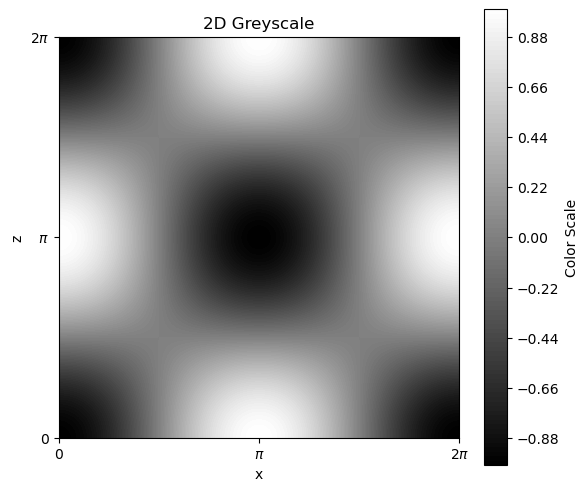

In [98]:
import numpy as np
import matplotlib.pyplot as plt

def psi(x, z):
    return -np.cos(x) * np.cos(z)

# plot the function in 2D greyscale (x, z) -> f(x, z)
fig, ax = plt.subplots(figsize=(6,6))
X = np.linspace(0, 2*np.pi, 100)
Z = np.linspace(0, 2*np.pi, 100)
X, Z = np.meshgrid(X, Z)
Y = psi(X, Z)

contour = ax.contourf(X, Z, Y, 100, cmap='gray')
ax.set_xlabel('x')
ax.set_ylabel('z')

# set the tickers to only show pi and 2pi
ax.set_xticks([0, np.pi, 2*np.pi])
ax.set_xticklabels(['0', '$\pi$', '$2\pi$'])
ax.set_yticks([0, np.pi, 2*np.pi])
ax.set_yticklabels(['0', '$\pi$', '$2\pi$'])
ax.set_aspect('equal')
ax.set_title('2D Greyscale')
# set bar to show the color scale
cbar = fig.colorbar(contour, shrink=0.8)
cbar.ax.set_ylabel('Color Scale')

plt.tight_layout()
plt.show()


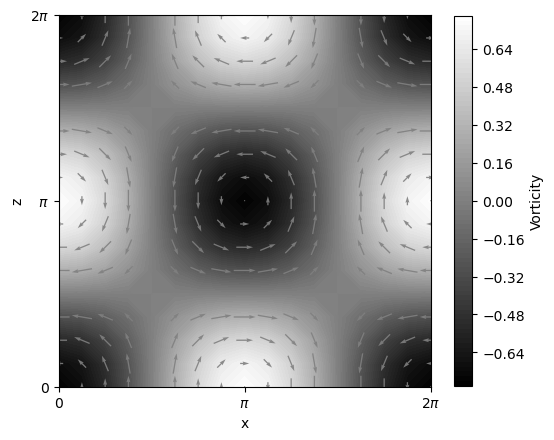

In [97]:
import numpy as np
import matplotlib.pyplot as plt

def u(x, z):
    return -np.cos(x) * np.sin(z)

def v(x, z):
    return np.sin(x) * np.cos(z)

# define function w(u,v) caculate vorticity of the vector field
def w(u, v):# w = d(v)/dx - d(u)/dy
    return np.gradient(v, axis=1) - np.gradient(u, axis=0)

# plot the vector graph of Taylor-Green vortex
fig, ax = plt.subplots(figsize=(6,6))
X, Z = np.meshgrid(np.linspace(0, 2*np.pi, 17), np.linspace(0, 2*np.pi, 17))
U = u(X, Z)
V = v(X, Z)
contour = ax.contourf(X, Z, -w(U, V), 100, cmap='gray')
ax.quiver(X, Z, U, V, angles='uv', scale_units='xy', scale=2.5, pivot='mid', alpha=0.9, color='grey')
ax.set_xlabel('x')
ax.set_ylabel('z')
ax.set_aspect('equal')
# set the tickers to only show pi and 2pi
ax.set_xticks([0, np.pi, 2*np.pi])
ax.set_xticklabels(['0', '$\pi$', '$2\pi$'])
ax.set_yticks([0, np.pi, 2*np.pi])
ax.set_yticklabels(['0', '$\pi$', '$2\pi$'])
cbar = fig.colorbar(contour,shrink=0.8)
cbar.ax.set_ylabel('Vorticity')
plt.show()


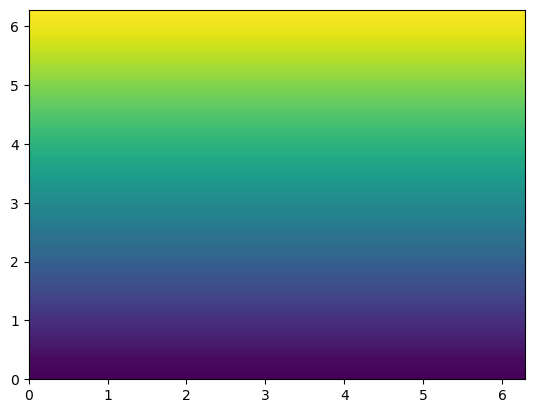

In [95]:
plt.contourf(X, Z, np.gradient(Z**2,axis=0),100)

## Learning Gymnasium and Baseline3

In [5]:
# 定义涡场和动力学方程
def omega_hat(x, z, length = 1):
    if length == 1:
        return np.cos(x)*np.cos(z)
    elif length == 3:
        return np.array([0,0,np.cos(x)*np.cos(z)])
        
def u_hat(x, z):
    return np.array([-np.cos(x)*np.sin(z)/2, np.sin(x)*np.cos(z)/2])

def eta(): # eta = (eta_x, eta_z)
    return np.random.normal(0, 1, 2)

def xi():
    return np.random.normal(0, 1)

def p(theta_p, length = 2): # p = (p_x, p_z) (default) or (p_x, p_z, p_y) (length = 3)
    if length == 2:
        return np.array([np.cos(theta_p),np.sin(theta_p)])
    elif length == 3:
        return np.array([np.cos(theta_p),np.sin(theta_p),0])
    
def delta_X(x, z, theta_p, Phi, D0, u0): # delta_X = (delta_x, delta_z)
    return u0*(u_hat(x, z)+Phi*np.array([np.cos(theta_p),np.sin(theta_p)]))+np.sqrt(2*D0)*eta()

def delta_theta_p(x, z, theta_p, ka, Psi, B, DR):
    delta_p0 = 1/(2*B) * ((ka-np.dot(ka,p(theta_p))*p(theta_p))+Psi* np.cross(omega_hat(x, z, 3),p(theta_p, 3))[:2])
    delta_p = np.linalg.norm(delta_p0)+ np.sqrt(2*DR)*xi()
    return delta_p



In [6]:
# 定义环境
import gymnasium as gym
from gymnasium import spaces
import numpy as np

dictOfVorticity = {0: "w-",1: "w0",2: "w+"}
dictOfDirection = {0: "up",1: "left",2: "down",3: "right"}
dictOfActions = {0: "up",1: "left",2: "down",3: "right"}

class CustomEnv(gym.Env): # 继承gym.Env类
    def __init__(self, Phi = 0, Psi = 0, B = 1, u0 = 1, D0 = 1, DR = 1, dt = 0.1): # 初始化函数
        super(CustomEnv, self).__init__() # 必须调用父类的构造函数
        self.Phi = Phi
        self.Psi = Psi
        self.B = B
        self.u0 = u0
        self.D0 = D0
        self.DR = DR
        self.dt = dt
        # 定义观测空间, 状态空间和动作空间
        # Observation space will be a dict of two discrete values
        self.observation_space = spaces.Dict({
            "vorticity": spaces.Discrete(3),# dictOfVorticity.keys()
            "direction": spaces.Discrete(4)# dictOfDirection.keys()
        })
        # State space will be a dict of two continuous values
        self.low = np.array([0,0])
        self.high = np.array([2*np.pi,2*np.pi])
        self.state_space = spaces.Dict({
            "position" : spaces.Box(self.low, self.high, dtype=np.float32),
            "direction_theta_p": spaces.Box(low = 0, high = 2*np.pi, shape = (1,), dtype=np.float32)
            })
        # Action space will be a discrete set of 4 actions
        self.action_space = spaces.Discrete(4)# dictOfActions.keys()
        # 定义动作到方向的映射字典
        self._action_to_ka = {
            0: np.array([0, 1]),
            1: np.array([-1, 0]),
            2: np.array([0, -1]),
            3: np.array([1, 0]),
        }
        # 初始化状态和观测
        self.observation = self.reset()
        
    def reset(self,seed = None):    
        super().reset(seed=seed) # 重置环境   
        self.state = self.state_space.sample() # 初始化状态
        self.observation = self._get_obs()
        info = {'position': self.state['position']} # 初始化信息 
        return self.observation, info# 返回初始化状态
    
    def step(self, action):
        # dynamics
        ka = self._action_to_ka[action]
        delta_x = delta_X(self.state["position"][0], self.state["position"][1], self.state["direction_theta_p"][0], self.Phi, self.D0, self.u0)
        self.state["position"] += delta_x*self.dt
        self.state["direction_theta_p"] += delta_theta_p(self.state["position"][0], self.state["position"][1], self.state["direction_theta_p"][0], ka, self.Psi, self.B, self.DR)*self.dt
        self.state["direction_theta_p"] = self.state["direction_theta_p"] % (2*np.pi)
        # observation
        observation = self._get_obs()
        # reward
        reward = delta_x[1]
        # terminated
        terminated = bool(self.state['position'][1] - self.high[1] >= 0)
        # truncated
        truncated = not(self.state_space.contains(self.state))
        info  = {'position': self.state['position']}
        return observation, reward, terminated, truncated, info
    
    def _get_obs(self):
        self.observation  = self.observation_space.sample()
        w = omega_hat(self.state["position"][0], self.state["position"][1])
        theta_p = self.state['direction_theta_p']
        if w >= -1 and w < -0.33:
            self.observation["vorticity"] = 0
        elif w >= -0.33 and w <= 0.33:
            self.observation["vorticity"] = 1
        elif w > 0.33 and w <= 1:
            self.observation["vorticity"] = 2
        
        if theta_p >= np.pi/4 and theta_p < 3*np.pi/4:
            self.observation["direction"] = 0
        elif theta_p >= 3*np.pi/4 and theta_p < 5*np.pi/4:
            self.observation["direction"] = 1
        elif theta_p >= 5*np.pi/4 and theta_p < 7*np.pi/4:
            self.observation["direction"] = 2
        else :
            self.observation["direction"] = 3
        return self.observation




In [ ]:
# 训练
import numpy as np



# 创建环境
env = CustomEnv(Phi= 1, Psi=0.1, B=1, u0=1, D0=1, DR=1, dt=0.05)

# 初始化 Q-table
n_state_dir = env.observation_space['direction'].n
n_state_vor = env.observation_space['vorticity'].n
n_actions = env.action_space.n
Q = np.zeros((n_state_dir,n_state_vor, n_actions))

# Q-learning 参数
learning_rate = 0.1
discount_factor = 0.95
exploration_prob = 0
num_episodes = 1000 #1000
pos = []

# Q-learning 训练
for episode in range(num_episodes):
    state, info = env.reset()
    done = False
    step = 0

    while not done:
        # 选择动作,例如 epsilon-greedy
        if np.random.rand() < exploration_prob:
            action = env.action_space.sample()  # 随机动作
        else:
            action = np.argmax(Q[state['direction'], state['vorticity'], :])  # 选择 Q 值最大的动作

        # 执行动作并观察环境
        next_state, reward, ter, tru, info = env.step(action)
        done = ter
        pos += [info['position'].copy()]
        
        # 更新 Q 值, Q(s,a) = (1-alpha) * Q(s,a) + alpha * (r + gamma * maxQ(s',a'))
        Q[state['direction'], state['vorticity'], action] = (1 - learning_rate) * Q[state['direction'], state['vorticity'], action] + \
                           learning_rate * (reward + discount_factor * np.max(Q[next_state['direction'], next_state['vorticity'], :]))

        state = next_state
        step+=1
        print('episode:', episode, 'step', step)
        if step >10000:
            break


In [26]:
class QLearningAgent:
    def __init__(self, env, learning_rate=0.1, discount_factor=0.95, exploration_prob=0, num_episodes=1000, max_steps = 10000):
        self.env = env
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.exploration_prob = exploration_prob
        self.num_episodes = num_episodes
        self.max_steps = max_steps
        self.n_state_dir = env.observation_space['direction'].n
        self.n_state_vor = env.observation_space['vorticity'].n
        self.n_actions = env.action_space.n
        self.Q = np.zeros((self.n_state_dir, self.n_state_vor, self.n_actions))
        self.pos = []

    def train(self):
        for episode in range(self.num_episodes):
            state, info = self.env.reset()
            done = False
            step = 0

            while not done:
                # 选择动作,例如 epsilon-greedy
                if np.random.rand() < self.exploration_prob:
                    action = self.env.action_space.sample()  # 随机动作
                else:
                    action = np.argmax(self.Q[state['direction'], state['vorticity'], :])  # 选择 Q 值最大的动作

                # 执行动作并观察环境
                next_state, reward, ter, tru, info = self.env.step(action)
                done = ter
                self.pos += [info['position'].copy()]

                # 更新 Q 值, Q(s,a) = (1-alpha) * Q(s,a) + alpha * (r + gamma * maxQ(s',a'))
                self.Q[state['direction'], state['vorticity'], action] = (1 - self.learning_rate) * self.Q[state['direction'], state['vorticity'], action] + \
                                   self.learning_rate * (reward + self.discount_factor * np.max(self.Q[next_state['direction'], next_state['vorticity'], :]))

                state = next_state
                step+=1
                print('episode:', episode, 'step', step)
                if step > self.max_steps:
                    break

    def test(self, num_episodes=100):
        returns = []
        trajectories = []
        for episode in range(num_episodes):
            state, info = self.env.reset()
            done = False
            episode_return = 0
            trajectory = [info['position'].copy()]

            while not done:
                action = np.argmax(self.Q[state['direction'], state['vorticity'], :])
                next_state, reward, done, _, info = self.env.step(action)
                episode_return += reward
                trajectory.append(info['position'].copy())
                state = next_state

            returns.append(episode_return)
            trajectories.append(trajectory)

        avg_return = np.mean(returns)
        return avg_return, trajectories


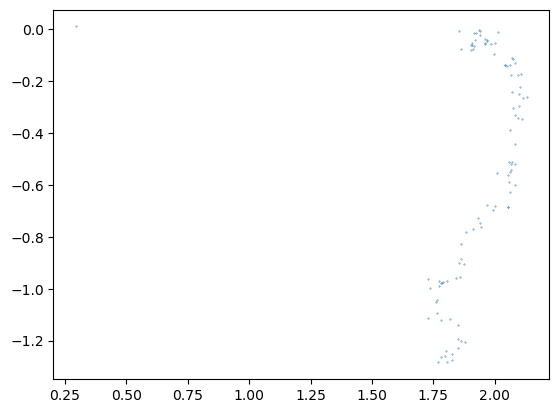

In [25]:
import matplotlib.pyplot as plt
pos = np.array(pos)
plt.scatter(pos[-100:-1,0]/np.pi,pos[-100:-1,1]/np.pi-2, s=0.1) # 画出轨迹


In [71]:
# matplotlib inline

import gymnasium as gym
import itertools
import matplotlib
import numpy as np
import pandas as pd
import sys


if "../" not in sys.path:
  sys.path.append("../") 

from collections import defaultdict
env = gym.make('CliffWalking-v0')
import matplotlib.pyplot as plotting

matplotlib.style.use('ggplot')

In [72]:
def make_epsilon_greedy_policy(Q, epsilon, nA):
    """
    Creates an epsilon-greedy policy based on a given Q-function and epsilon.
    
    Args:
        Q: A dictionary that maps from state -> action-values.
            Each value is a numpy array of length nA (see below)
        epsilon: The probability to select a random action. Float between 0 and 1.
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes the observation as an argument and returns
        the probabilities for each action in the form of a numpy array of length nA.
    
    """
    def policy_fn(observation):
        A = np.ones(nA, dtype=float) * epsilon / nA
        best_action = np.argmax(Q[observation])
        A[best_action] += (1.0 - epsilon)
        return A
    return policy_fn

In [75]:
def q_learning(env, num_episodes, discount_factor=1.0, alpha=0.5, epsilon=0.1):
    """
    Q-Learning algorithm: Off-policy TD control. Finds the optimal greedy policy
    while following an epsilon-greedy policy
    
    Args:
        env: OpenAI environment.
        num_episodes: Number of episodes to run for.
        discount_factor: Gamma discount factor.
        alpha: TD learning rate.
        epsilon: Chance to sample a random action. Float between 0 and 1.
    
    Returns:
        A tuple (Q, episode_lengths).
        Q is the optimal action-value function, a dictionary mapping state -> action values.
        stats is an EpisodeStats object with two numpy arrays for episode_lengths and episode_rewards.
    """
    
    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    Q = defaultdict(lambda: np.zeros(env.action_space.n))

    # Keeps track of useful statistics
    # stats = plotting.EpisodeStats(
    #     episode_lengths=np.zeros(num_episodes),
    #     episode_rewards=np.zeros(num_episodes))    
    
    # The policy we're following
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
    
    for i_episode in range(num_episodes):
        # Print out which episode we're on, useful for debugging.
        if (i_episode + 1) % 100 == 0:
            print("\rEpisode {}/{}.".format(i_episode + 1, num_episodes), end="")
            sys.stdout.flush()
        
        # Reset the environment and pick the first action
        state = env.reset()
        
        # One step in the environment
        # total_reward = 0.0
        for t in itertools.count():
            
            # Take a step
            action_probs = policy(state)
            action = np.random.choice(np.arange(len(action_probs)), p=action_probs)
            next_state, reward, done, _ = env.step(action)

            # Update statistics
            stats.episode_rewards[i_episode] += reward
            stats.episode_lengths[i_episode] = t
            
            # TD Update
            best_next_action = np.argmax(Q[next_state])    
            td_target = reward + discount_factor * Q[next_state][best_next_action]
            td_delta = td_target - Q[state][action]
            Q[state][action] += alpha * td_delta
                
            if done:
                break
                
            state = next_state
    
    return Q, stats